https://blog.langchain.dev/reflection-agents/

In [1]:
from IPython.display import Image

- Andrew NG, agentic reasoing
- reflexion agent
    - reflect on and critique its past actions,
    - sometimes incorporating additional external information such as tool observations.
        - execution
-  "System 1" vs. "System 2" thinking,
    - where System 1 is reactive or instinctive （fast thinking）
    - System 2 is more methodical and reflective （slow thinking）
        - o1
    - reflection can help LLM systems break out of purely System 1 "thinking" patterns and closer to something exhibiting System 2-like behavior.
- reflexion agent
    - 本质是对 messages 的操作和管理（左右互搏）
        - generator vs. reflector
            - 对于 generator 的输出，ai message（assistant），对于 reflector 则是 human message（user）
            - 反之对于 reflector 的输出，ai message（assistant），对于 generator 则是 human message（user）

In [2]:
Image(url='https://miro.medium.com/v2/resize:fit:4800/format:webp/0*2CQ5PdQGvmvdg1P2.png', width=400)

In [3]:
Image(url='https://neurofied.com/wp-content/uploads/2022/05/System-12-White-1.png', width=400)

### basic reflection

In [4]:
Image(url='https://blog.langchain.dev/content/images/size/w1000/2024/02/reflection.png', width=400)

In [5]:
from dotenv import load_dotenv
assert load_dotenv()

#### generate

- `ChatPromptTemplate` 实例化之后是 `ChatPromptValue`
- `.stream()` 而非 `.invoke()`，长文的输出就显得没有那么耗时；
- system prompt 不属于 messages

In [6]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

In [7]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [8]:
prompt.pretty_print()

================================ System Message ================================

You are an essay assistant tasked with writing excellent 5-paragraph essays. Generate the best essay possible for the user's request. If the user provides critique, respond with a revised version of your previous attempts.

============================= Messages Placeholder =============================

{messages}


In [9]:
llm = ChatOpenAI(model='gpt-4o-2024-08-06')

In [10]:
generate = prompt | llm

In [11]:
prompt

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [12]:
prompt.invoke({'messages': [('human', 'write an essay on why the little prince is relevant in modern childhood')]})

ChatPromptValue(messages=[SystemMessage(content="You are an essay assistant tasked with writing excellent 5-paragraph essays. Generate the best essay possible for the user's request. If the user provides critique, respond with a revised version of your previous attempts.", additional_kwargs={}, response_metadata={}), HumanMessage(content='write an essay on why the little prince is relevant in modern childhood', additional_kwargs={}, response_metadata={})])

In [13]:
prompt.invoke({'messages': [HumanMessage(content='write an essay on why the little prince is relevant in modern childhood')]})

ChatPromptValue(messages=[SystemMessage(content="You are an essay assistant tasked with writing excellent 5-paragraph essays. Generate the best essay possible for the user's request. If the user provides critique, respond with a revised version of your previous attempts.", additional_kwargs={}, response_metadata={}), HumanMessage(content='write an essay on why the little prince is relevant in modern childhood', additional_kwargs={}, response_metadata={})])

In [14]:
resp = generate.invoke({'messages': 
                        [HumanMessage(content='write an essay on why the little prince is relevant in modern childhood')]})

In [15]:
print(resp.content)

Antoine de Saint-Exupéry's "The Little Prince" is a timeless tale that continues to resonate with readers of all ages, especially children. While the book was first published in 1943, its themes remain pertinent in today's rapidly changing world. The story's exploration of imagination, the value of relationships, and the critique of adult behavior offers vital life lessons that modern children can benefit from. This essay will delve into these aspects, illustrating why "The Little Prince" is relevant in contemporary childhood.

Firstly, "The Little Prince" celebrates the boundless creativity and imagination inherent in children. In today's digital age, where structured activities and screen time often dominate, the book serves as a reminder of the importance of nurturing a child's imagination. The protagonist's journey across various planets and encounters with whimsical characters like the fox and the talking rose encourage children to think beyond the confines of their everyday exper

In [16]:
essay = ""
request = HumanMessage(
    content='write an essay on why the little prince is relevant in modern childhood'
)
for chunk in generate.stream({'messages': [request]}):
    print(chunk.content, end="")
    essay += chunk.content

Antoine de Saint-Exupéry's "The Little Prince" is a timeless classic that continues to hold significant relevance in modern childhood. Although first published in 1943, its themes of innocence, imagination, and the essence of human relationships resonate as deeply today as they did over seventy years ago. The story's ability to transcend time and cultural boundaries makes it a valuable tool for imparting important life lessons to children in the contemporary world. This essay will explore three key reasons why "The Little Prince" remains relevant: its emphasis on the value of imagination, its exploration of essential human connections, and its critique of adult perspectives.

Firstly, "The Little Prince" serves as a profound reminder of the value of imagination in childhood. In today's digital age, children's imaginations are often stifled by screens and structured activities. The Little Prince, with his fantastical journey across planets, encourages children to engage their creativity

#### Reflect

In [17]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [18]:
reflection_prompt.pretty_print()

================================ System Message ================================

You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission. Provide detailed recommendations, including requests for length, depth, style, etc.

============================= Messages Placeholder =============================

{messages}


In [19]:
reflect = reflection_prompt | llm

In [20]:
reflection_prompt.invoke({'messages': [HumanMessage(content=essay)]}).messages

[SystemMessage(content="You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission. Provide detailed recommendations, including requests for length, depth, style, etc.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Antoine de Saint-Exupéry\'s "The Little Prince" is a timeless classic that continues to hold significant relevance in modern childhood. Although first published in 1943, its themes of innocence, imagination, and the essence of human relationships resonate as deeply today as they did over seventy years ago. The story\'s ability to transcend time and cultural boundaries makes it a valuable tool for imparting important life lessons to children in the contemporary world. This essay will explore three key reasons why "The Little Prince" remains relevant: its emphasis on the value of imagination, its exploration of essential human connections, and its critique of adult perspectives.\n\nFirstly, "The Little 

In [21]:
resp = reflect.invoke({'messages': [HumanMessage(content=essay)]})

In [22]:
print(resp.content)

Your essay provides a thoughtful and engaging analysis of Antoine de Saint-Exupéry's "The Little Prince," highlighting its enduring relevance and appeal to modern readers, particularly children. Your focus on the themes of imagination, human connection, and critique of adult perspectives is well-chosen, and you effectively articulate why these themes resonate today. However, there are areas where your essay could be strengthened to provide a more comprehensive and nuanced exploration.

### Critique and Recommendations:

1. **Depth of Analysis:**
   - While you touch on the themes effectively, consider delving deeper into specific instances from the text to illustrate your points. For example, when discussing the value of imagination, you could analyze particular episodes, such as the Little Prince's encounter with the fox, to show how these moments encapsulate the theme.
   - Explore the philosophical underpinnings of the novel. For instance, how does Saint-Exupéry’s personal history a

In [23]:
request.type

'human'

In [24]:
reflection_prompt.invoke({'messages': [request, HumanMessage(content=essay)]}).messages

[SystemMessage(content="You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission. Provide detailed recommendations, including requests for length, depth, style, etc.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='write an essay on why the little prince is relevant in modern childhood', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Antoine de Saint-Exupéry\'s "The Little Prince" is a timeless classic that continues to hold significant relevance in modern childhood. Although first published in 1943, its themes of innocence, imagination, and the essence of human relationships resonate as deeply today as they did over seventy years ago. The story\'s ability to transcend time and cultural boundaries makes it a valuable tool for imparting important life lessons to children in the contemporary world. This essay will explore three key reasons why "The Little Prince" remains relevant: its emphasis

In [25]:
reflection = ''
for chunk in reflect.stream({'messages': [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Your essay on the relevance of "The Little Prince" in modern childhood is well-structured and covers three significant themes: the value of imagination, the importance of human connections, and the critique of adult perspectives. Your points are clearly articulated, and you effectively demonstrate how these themes continue to resonate in today's world. However, there are areas where the essay could be further developed to enhance its depth and impact.

### Recommendations:

1. **Length and Depth:**
   - **Expand on Examples:** While you touch upon the themes, adding specific examples from the book would strengthen your argument. For instance, discuss the Little Prince's interaction with the fox to illustrate the importance of relationships and how it teaches the lesson that "what is essential is invisible to the eye."
   - **Contemporary Connections:** Consider drawing parallels between the book's themes and current issues or trends in childhood development. For instance, you could exp

#### Repeat

In [26]:
request

HumanMessage(content='write an essay on why the little prince is relevant in modern childhood', additional_kwargs={}, response_metadata={})

In [27]:
print(reflection)

Your essay on the relevance of "The Little Prince" in modern childhood is well-structured and covers three significant themes: the value of imagination, the importance of human connections, and the critique of adult perspectives. Your points are clearly articulated, and you effectively demonstrate how these themes continue to resonate in today's world. However, there are areas where the essay could be further developed to enhance its depth and impact.

### Recommendations:

1. **Length and Depth:**
   - **Expand on Examples:** While you touch upon the themes, adding specific examples from the book would strengthen your argument. For instance, discuss the Little Prince's interaction with the fox to illustrate the importance of relationships and how it teaches the lesson that "what is essential is invisible to the eye."
   - **Contemporary Connections:** Consider drawing parallels between the book's themes and current issues or trends in childhood development. For instance, you could exp

In [28]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

Antoine de Saint-Exupéry's "The Little Prince" is a timeless narrative that maintains its profound relevance in modern childhood. Despite being over seventy years old, the book's themes of imagination, the essence of human connections, and its critique of adult perspectives continue to resonate deeply with today's readers. As children grow up in an increasingly fast-paced, digital world, "The Little Prince" offers invaluable lessons that nurture their development. This essay will delve into specific examples from the book to explore its relevance, draw contemporary connections, and suggest practical ways to incorporate its lessons into children's lives.

Firstly, "The Little Prince" emphasizes the value of imagination, which is essential for children's cognitive and emotional development. In a world where screens often dominate children's attention, the book encourages imaginative exploration through its fantastical narrative. The Little Prince’s journey across different planets, each 

### construct Graph

In [29]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

In [30]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [31]:
async def generation_node(state: State) -> State:
    print('generation node', [msg.type for msg in state['messages']])
    return {"messages": [await generate.ainvoke(state["messages"])]}


async def reflection_node(state: State) -> State:
    print('reflection node raw', [msg.type for msg in state['messages']])
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    print('reflection node processed', [msg.type for msg in translated])
    res = await reflect.ainvoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}

- messages
    - round 1
        - generate
            - input: [`human`]
            - output: [`human`, `ai`]
        - reflect
            - input: [`human`, `ai`] -> [`human`, `human`]
            - output: [`human`, `ai`, `human`]
                - 问题，回答，反思
    - round 2
        - generate
            - input: [`human`, `ai`, `human`]
            - output: [`human`, `ai`, `human`, `ai`]
                - 问题，回答，反思，改进后的回答
        - reflect
            - input: [`human`, `ai`, `human`, `ai`] => [`human`, `human`, `ai`, `human`]
            - output: [`human`, `ai`, `human`, `ai`, `human`]
    - round 3
        - generate
            - input: [`human`, `ai`, `human`, `ai`, `human`] 
            - output: [`human`, `ai`, `human`, `ai`, `human`, `ai`]
        - reflect
            - input: [`human`, `ai`, `human`, `ai`, `human`, `ai`] => [`human`, `human`, `ai`, `human`, `ai`, `human`]
            - output: [`human`, `ai`, `human`, `ai`, `human`, `ai`, `human`]
    - round4
        - generate
            - input: [`human`, `ai`, `human`, `ai`, `human`, `ai`, `human`]
            - output: [`human`, `ai`, `human`, `ai`, `human`, `ai`, `human`, `ai`]

In [32]:
builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")

def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations
        return END
    return "reflect"

In [33]:
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

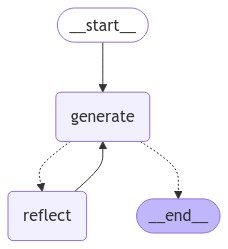

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [35]:
config = {"configurable": {"thread_id": "1"}}

In [36]:
async for event in graph.astream(
    {
        "messages": [
            HumanMessage(
                content="Generate an essay on the topicality of The Little Prince and its message in modern life"
            )
        ],
    },
    config,
):
    print(event)
    print("---")

generation node ['human']
{'generate': {'messages': [AIMessage(content='Antoine de Saint-Exupéry\'s timeless masterpiece, "The Little Prince," continues to resonate profoundly with readers across the globe, transcending cultural and generational boundaries. Written in 1943, the novella’s exploration of human nature, relationships, and the essence of life remains remarkably relevant in today\'s world. Its enduring topicality lies in its poignant message about the importance of seeing with the heart, the critique of adult preoccupations, and the celebration of childlike wonder.\n\nAt the core of "The Little Prince" is the exploration of human relationships and the recognition of essential truths that are often invisible to the eye. In a world increasingly dominated by technology and superficial connections, the novella\'s message about the importance of genuine relationships is more pertinent than ever. The Little Prince\'s encounters with various characters, such as the fox, emphasize t

In [37]:
resp = await graph.ainvoke({
        "messages": [
            HumanMessage(
                content="Generate an essay on the topicality of The Little Prince and its message in modern life"
            )
        ],
    },
    config,
)

generation node ['human', 'ai', 'human', 'ai', 'human', 'ai', 'human', 'ai', 'human']


In [38]:
for msg in resp['messages']:
    print(msg.type)

human
ai
human
ai
human
ai
human
ai
human
ai
